What is Parallelization in LangGraph?

In LangGraph, nodes typically execute in a sequence defined by edges, but when tasks don't depend on each other's output, you can run them in parallel. This is achieved by:

- Defining multiple nodes that can operate independently.
- Connecting them to a common starting point (eg., START or another node).
- Merging their outputs into a downstream node if needed.

LangGraph handles this implecitly when nodes are independent and can leverage multi-threading or asynchronous execution under the hood, depending on the runtime environment (e.g., Python's asyncio or a multi-threaded executor).



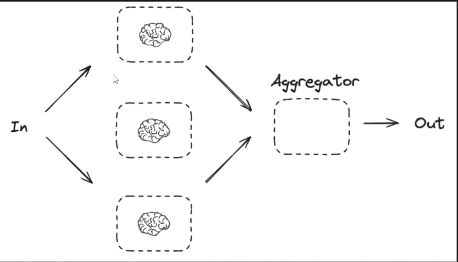

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq

os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

LLM = ChatGroq(model='llama-3.1-8b-instant')

result = LLM.invoke("Hello")
result

AIMessage(content='How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 36, 'total_tokens': 44, 'completion_time': 0.010222954, 'prompt_time': 0.002094398, 'queue_time': 0.049651201, 'total_time': 0.012317352}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_e32974efee', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--78c99852-bce0-43c4-8f07-1fa2c6e382f9-0', usage_metadata={'input_tokens': 36, 'output_tokens': 8, 'total_tokens': 44})

In [3]:
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph State

class State(BaseModel):
    topic: str = ''
    characters: str = ''
    settings: str = ''
    premisis: str = ''
    story_intro: str = ''


In [4]:
# initalizing nodes

def characters(state: State):
    """Generate Character Description"""
    msg = LLM.invoke(f"Create two character names and brief traits for a story about {state.topic}")
    return {"characters": msg.content}

def premise(state: State):
    """Generate a Story premise"""
    msg = LLM.invoke(f"Write a one-sentence plot premise for a story about {state.premisis}")
    return {"premises": msg.content}
def setting(state: State):
    """Generate a story setting"""
    msg = LLM.invoke(f"Describe a vivid setting for a story about {state.settings}")
    return {"settings": msg.content}
def combine(state: State):
    """Combine characters, setting, and premise into an intro"""

    msg = LLM.invoke(
        f"Write a short story introduction using these elements:\n"
        f"Characters: {state.characters}\n"
        f"Setting: {state.settings}\n"
        f"Premise: {state.premisis}"
    )

    return {"story_intro": msg.content}



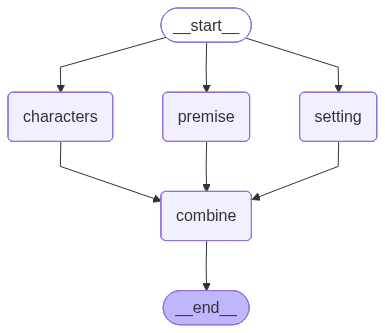

In [5]:
# Building the graph
builder = StateGraph(State)

builder.add_node('characters', characters)
builder.add_node('premise', premise) 
builder.add_node('setting', setting)
builder.add_node('combine', combine)

builder.add_edge(START, 'characters')
builder.add_edge(START, 'premise')
builder.add_edge(START, 'setting')
builder.add_edge('characters', 'combine')
builder.add_edge('premise', 'combine')
builder.add_edge('setting', 'combine')

graph = builder.compile()
graph_image = graph.get_graph().draw_mermaid_png()
display(Image(graph_image))


In [7]:
state = {"topic": "time travel"}
result = graph.invoke(state)
print(result['story_intro'])

As the last rays of sunlight faded beyond the horizon, casting the Enchanted Lagoon of Luminaria in a soft, ethereal glow, Emily "Evie" Thompson stood at the edge of the weathered wooden dock, her eyes fixed on the tranquil waters below. The lagoon's surface rippled gently, as if responding to the subtle lapping of the waves against the shore. The air was heavy with the sweet scent of blooming water lilies, and the soft songs of exotic birds filled the night air.

Evie's thoughts were a world away from this serene setting, however. Her mind was preoccupied with the impending launch of their time-traveling vessel, the "Chrono's Quest," and the mission that lay ahead. She had spent countless hours poring over ancient texts and historical records, pouring her knowledge of the past into the project. But it was Ethan Blackwood, the brilliant physicist who had created the technology that would allow them to traverse the ages, who was the true driving force behind their endeavor.

Ethan stood

## Key Benefits

- Speed: Reduces total execution time by running tasks concurrently.
- Scalability: Handles larger workflows effeciently.
- Modularity: Keeps the graph structure clean and reusable.

## Key Takeaways

- When to Parallelize: Use it for independent tasks(eg. generating multiple outputs, checking separate inputs).
- Merging: Downstream nodes can aggregate parallel results.
- LangGraph Support: The framework naturally supports this by waiting for all required inputs before proceeding.